### This notebook demostrates a non-linear multiple regression approach that is useful for many daily tasks of reservoir engineers estimating the value of horizontal multifrac'd wells. The example addresses the general estimation of EURs for potential drilling locations where analogous offsets and commonly associated data are available.

In [1]:
# import relevant modules:

import os

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit, differential_evolution, minimize
from scipy.stats import skew

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error


# settings:

plt.rcParams['figure.figsize'] = (12,7)
sns.set()

### The first section will address the generating phenomena, which are based on the basic physics of an oil reservoir under primary recovery by depletion / solution-gas drive.

### Populate these distributions for the following parameters:
- spacing, distance between laterals wellbores, perpendicular to wellbore (ft)
- phi, porosity (decimal)
- h, reservoir height (ft)
- Sw, water saturation (decimal)
- RF, recovery factor (decimal)


In [2]:
# the number of synthetic wells to be generated:
n = 1000
# I'll use an unusually high well count during the development of this method
# for ease of validity testing.

c:\envs\base\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

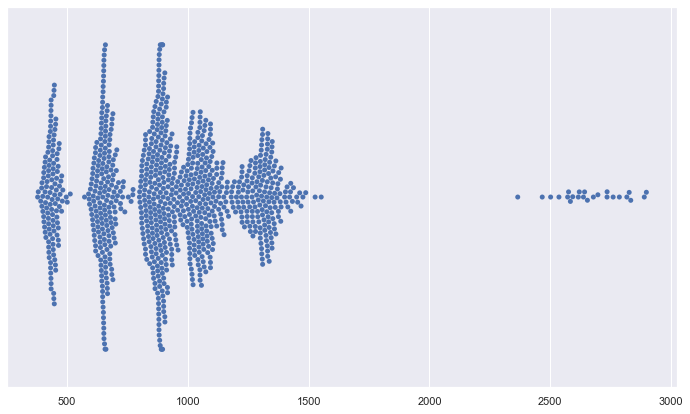

In [3]:
# add n fake wells at various spacings:

spacing = np.random.choice(np.concatenate([np.repeat(440, 6), 
                          np.repeat(660, 8),
                          np.repeat(880, 12), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)]), size=n)

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .05, n)

spacing = np.sort(spacing)

sns.swarmplot(spacing)

(0.0, 0.10123072878065358)

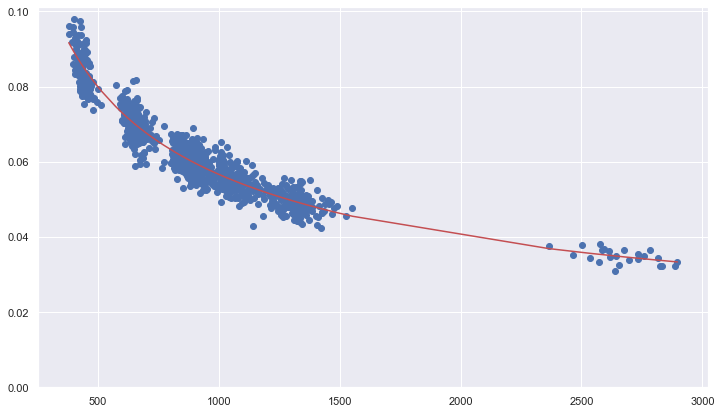

In [4]:
# generate the RF values based on a non-linear decreasing relationship to 
# spacing, based on the assumption that increased well density (decreased
# well spacing) results in higher recovery factors:

# RF0 = .1/(spacing**.2 + 0.3) + .1/(spacing**.2) - 0.0
RF0 = .9/(spacing**.5 + 0.3) + .9/(spacing**.5) - 0.0
RF_noise = np.random.normal(loc=1, scale=0.05, size=n)
RF = RF0 * RF_noise

plt.plot(spacing, RF0, c='r')
plt.scatter(x=spacing, y=RF)
plt.ylim(0,)

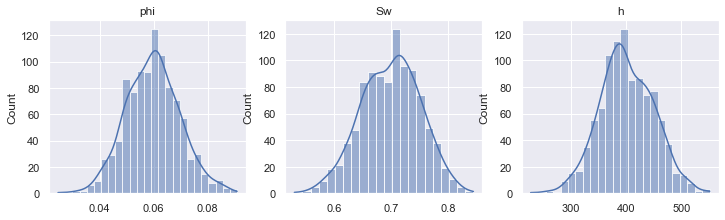

In [5]:
# finally, create the phi, Sw, and h distributions that reflect commonly observed real data:

phi = np.random.normal(loc=.06, scale=.01, size=n).clip(min=0.01)
Sw = np.random.normal(loc=.7, scale=.05, size=n).clip(min=0.4, max=.98)
h = np.random.normal(loc=400, scale=50, size=n).clip(min=0)

ax1 = plt.subplot(231)
ax1 = sns.histplot(phi, kde=True)
plt.title('phi')
ax2 = plt.subplot(232)
ax2 = sns.histplot(Sw, kde=True)
plt.title('Sw')
ax3 = plt.subplot(233)
ax3 = sns.histplot(h, kde=True)
plt.title('h');

In [6]:
# create a dafatframe for ease of viewing and manipulation:

df = pd.DataFrame({'spacing': spacing,
                  'phi': phi,
                  'Sw': Sw,
                  'h': h,
                  'RF': RF})


df.describe().T

count        mean         std         min         25%         50%  \
spacing  1000.0  943.611301  384.620870  379.709443  668.971476  901.023586   
phi      1000.0    0.059754    0.009968    0.024579    0.052947    0.059729   
Sw       1000.0    0.699268    0.051443    0.530963    0.663205    0.702930   
h        1000.0  401.310290   48.645981  227.715071  367.701073  397.512359   
RF       1000.0    0.061336    0.011983    0.030976    0.053164    0.059193   

                 75%          max  
spacing  1094.502868  2897.063562  
phi         0.066290     0.090920  
Sw          0.736456     0.843591  
h         435.686447   551.186296  
RF          0.067861     0.097885

In [7]:
# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.random.choice([45,45,45,45,45,33,31,35,52,55,65,72], size=n)

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, n)

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3/5 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], n)

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have problematic multicollinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df.head(10)

spacing       phi        Sw           h        RF  compl_bbl_per_ft  \
0  379.709443  0.065222  0.715032  447.522408  0.093893         47.676577   
1  382.358295  0.071968  0.742304  390.398738  0.096023         46.367825   
2  392.514826  0.045415  0.674780  389.394893  0.091893         45.957950   
3  396.507751  0.050607  0.631132  390.587998  0.086118         36.444194   
4  397.410434  0.041290  0.679241  484.423517  0.094603         57.865037   
5  397.691345  0.071285  0.715067  370.562340  0.095909         32.731003   
6  400.877113  0.044780  0.694272  376.770142  0.087853         46.434256   
7  401.321181  0.071503  0.686812  422.747053  0.097885         34.398259   
8  404.432476  0.057863  0.786073  425.733586  0.084422         46.444609   
9  404.615429  0.056345  0.563238  440.035610  0.092966         54.695434   

   compl_sd_conc  compl_lbs_sd_per_ft  
0             50          2383.828851  
1             50          2318.391227  
2             50          2297.897482  
3             40          1457.767744  
4             40          2314.601467  
5             30           981.930094  
6             30          1393.027687  
7             40          1375.930364  
8             30          1393.338262  
9             40          2187.817375

## Define a function for the initial population of fake well EURs, define a related cost function, and set related parameters.
### Utilize a modified sigmoid function, where
<ul>
    <li>L is the horizontal asymptote - the EUR for true stand-alone wells
    <li>k is the exponential factor - typically very small (k << 0.1)
    <li>b0 is the vertical axis intercept - the EUR two wells occupying the same position (zero spacing) would recover

In [8]:
# population/curve-fit function
# this function allows the user to set intuitively realistic bounds
# during the curve-fitting stage. Reasonable values for these can be 
# read from the spacing-EUR/ft plot.

def mod_sig(spacing, k, L, b0):
    LL = 2 * (L - b0)
    return LL / (1 + np.exp(-k * (spacing - 0))) - LL/2 + b0


# We expect error in EUR/ft to be lognormally distributed for a given state of
# the determinants we examine. So define a cost function that allows the curve_fit
# algorithm to measure error against the log of EUR/ft, while still allowing us to 
# choose constraints for the algorithm which fit our intuitive understanding (linear
# space) of the reservoir & the data, as noted above.

def cost(x, k, L, b0):
    return np.log(mod_sig(x, k, L, b0))


# Mean absolute error may be preferable here for a cost function, particularly
# if predicting single well results:

def mae(params):
    lny = np.log(y)
    lnyhat = np.log(mod_sig(x, params[0], params[1], params[2]))
    return abs(lny - lnyhat).sum()

### Populate the fake EUR data & add noise

In [9]:
# adjust the RF by 5% for 25% change in sand concentration:
sd_conc_factor = 0.1 / .25

# adjust the RF by 10% for every 25% change in compl fluid per ft:
fluid_pft_factor = 0.2 / .25

# df['eur_per_ft'] = df.apply(lambda x: mod_sig(x['spacing'], k, L, b0), axis=1)
df['RF'] = (1 + ((df['compl_sd_conc'] - 40) / 40) * (sd_conc_factor)) * df['RF']
df['RF'] = (1 + ((df['compl_bbl_per_ft'] - 45) / 45) * (fluid_pft_factor)) * df['RF']

# eur_noise = np.random.lognormal(sigma=np.std(df['eur_per_ft']) / 10, size=len(df))

# df['eur_per_ft'] = df['eur_per_ft'] + eur_noise

df['eurpft'] = 7758 * df['spacing'] * df['phi'] * (1 - df['Sw']) * df['RF'] * df['h'] / (43560 * 1.3)

df = df.sort_values('spacing')

df.sort_values('eurpft')

spacing       phi        Sw           h        RF  compl_bbl_per_ft  \
80    448.596819  0.048801  0.711936  227.715071  0.074977         46.090656   
285   692.699408  0.033435  0.735563  341.645641  0.051735         35.141654   
38    427.464981  0.045237  0.742766  334.874329  0.074481         36.725419   
84    451.168717  0.061425  0.843591  351.722830  0.084979         46.701258   
117   514.717458  0.041024  0.709885  368.232174  0.060817         34.350540   
..           ...       ...       ...         ...       ...               ...   
989  2677.908238  0.075437  0.709751  379.356948  0.050273         66.285955   
986  2636.910789  0.076216  0.674587  425.387492  0.046670         65.793601   
847  1272.407371  0.082091  0.636463  454.061111  0.075421         68.296502   
951  1381.567031  0.086456  0.598236  372.500873  0.073032         67.519228   
960  1411.291166  0.067923  0.573038  432.284632  0.073956         72.319351   

     compl_sd_conc  compl_lbs_sd_per_ft      eurpft  
80              30          1382.719669   14.750646  
285             40          1405.666168   14.830217  
38              40          1469.016761   16.996568  
84              30          1401.037746   17.749199  
117             40          1374.021587   18.795084  
..             ...                  ...         ...  
989             40          2651.438195  153.197365  
986             50          3289.680055  177.876885  
847             50          3414.825083  178.153059  
951             50          3375.961421  178.852121  
960             50          3615.967566  179.260527  

[1000 rows x 9 columns]

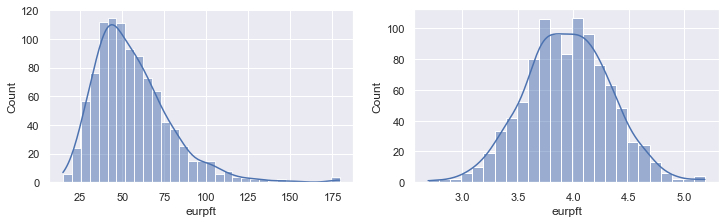

In [10]:
# examine & sense-check distribution of EUR/ft and ln(EUR/ft):

ax1 = plt.subplot(221)
ax1 = sns.histplot(df['eurpft'], kde=True)
ax2 = plt.subplot(222)
ax2 = sns.histplot(np.log(df['eurpft']), kde=True)

(0.0, 3022.9312680160465)

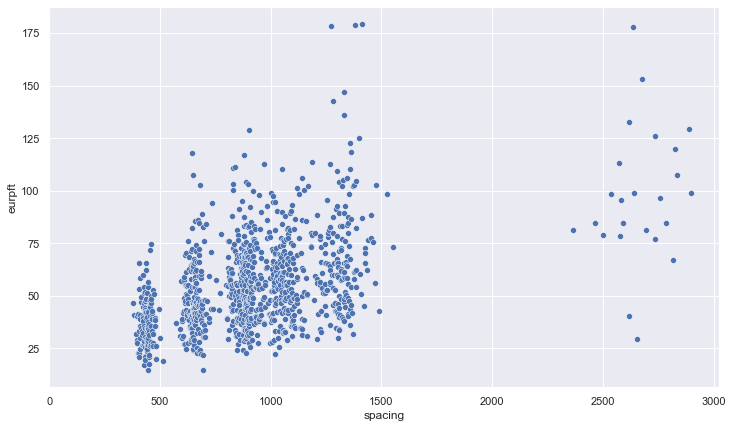

In [11]:
sns.scatterplot(data=df, x='spacing', y='eurpft')
plt.xlim(0, None)

(0.0, 5.313717875242829)

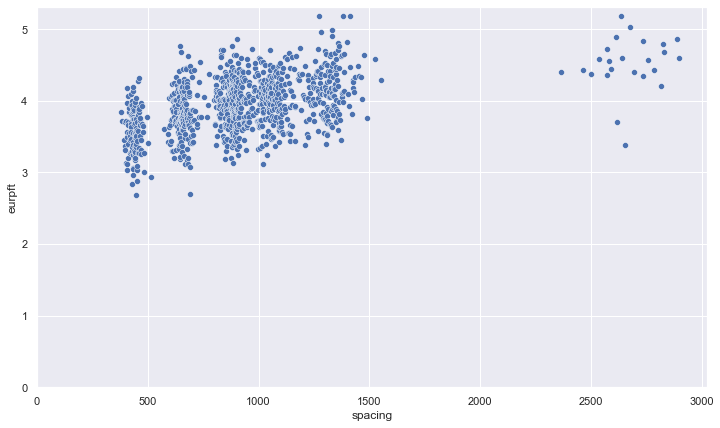

In [12]:
ax1 = sns.scatterplot(data=df, x='spacing', y=np.log(df['eurpft']))
plt.xlim(0, None)
plt.ylim(0, None)

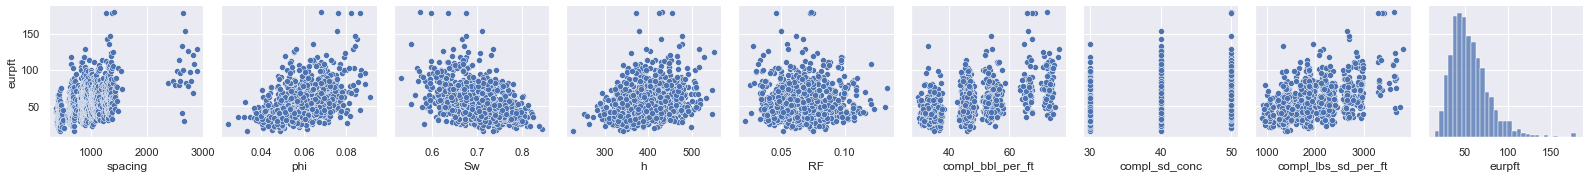

In [13]:
sns.pairplot(df, y_vars='eurpft')

Fit (MSE): k: 0.00085      L: 105.80      b0: 21.42
Fit (MAE): k: 0.00075      L: 113.89      b0: 22.91


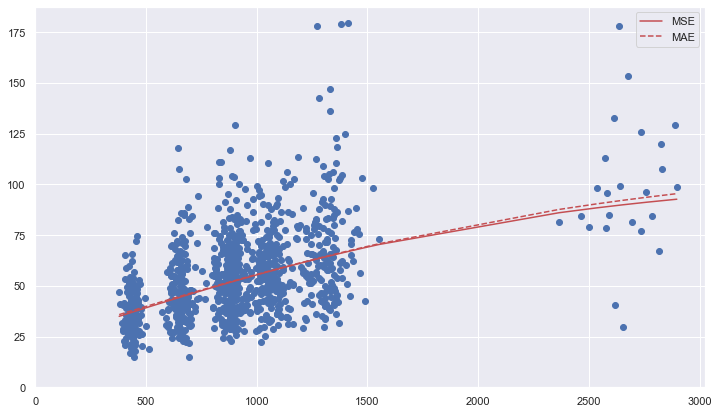

In [95]:
# define x & y space for the initial non-linear fit:
y = df['eurpft']
x = df['spacing'].values

# fit to log-space error using MSE (implicit to scipy curve_fit):
popt, _ = curve_fit(cost, x, np.log(y), bounds=([0, 70, 0], [.1, 200, 100]))


# # use differential evolution to fit log-space error using MAE:
de = differential_evolution(mae, bounds=[(0, .1), (70, 200), (0, 100)])
de_params = (de.x[0], de.x[1], de.x[2])

# # plot the curve fit vs. data
plt.scatter(x=x, y=y)
plt.plot(x, mod_sig(x, *popt), color='r', label='MSE')
plt.plot(x, mod_sig(x, *de_params), c='r', ls='--', label='MAE')
# plt.plot(x, mod_sig(x, k, L, b0), ls='-.', c='black', label='actual')
plt.xlim(0,)
plt.ylim(0,)
plt.legend()


print('Fit (MSE): k: %1.5f      L: %1.2f      b0: %1.2f' % tuple(popt))
print('Fit (MAE): k: %1.5f      L: %1.2f      b0: %1.2f' % tuple(de_params))

<AxesSubplot:xlabel='eurpft', ylabel='Count'>

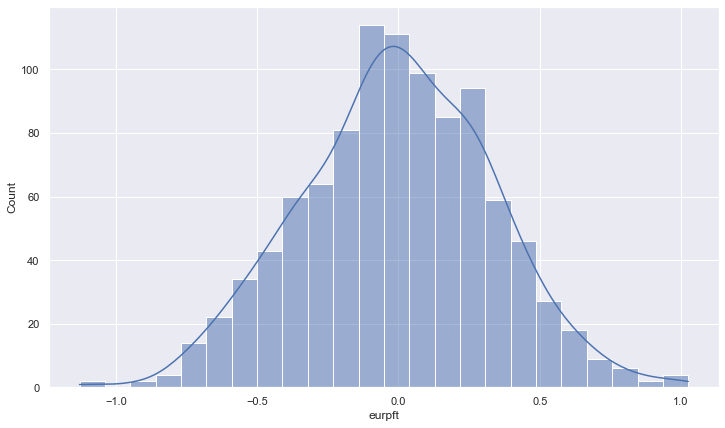

In [15]:
resid = np.log(y) - np.log(mod_sig(x, *de_params))
sns.histplot(resid, kde=True)

In [16]:
# create a df for the remaining determinants,
# to be used in a linear ordinary least squares regression:
dfols = df[['compl_bbl_per_ft', 'compl_sd_conc']]
dfols['logspace_resid'] = resid
dfols.head(10)

c:\envs\base\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


compl_bbl_per_ft  compl_sd_conc  logspace_resid
0         47.676577             50        0.304962
1         46.367825             50        0.170280
2         45.957950             50       -0.095788
3         36.444194             40       -0.194800
4         57.865037             40        0.143534
5         32.731003             30       -0.240029
6         46.434256             30       -0.429800
7         34.398259             40        0.157521
8         46.444609             30       -0.442965
9         54.695434             40        0.612939

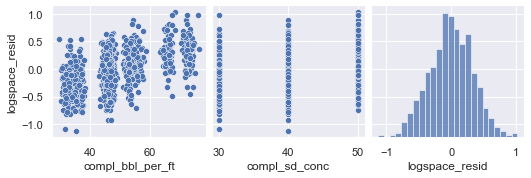

In [17]:
sns.pairplot(dfols, y_vars='logspace_resid')

In [18]:
# define exog and endog for the OLS regression:
Xols = sm.add_constant(dfols.drop('logspace_resid', axis=1))
yols = dfols['logspace_resid']

# define and fit the model:
ols = sm.OLS(yols, Xols)
ols_result = ols.fit()

# view a summary of the results:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         logspace_resid   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     235.1
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           2.24e-84
Time:                        23:27:34   Log-Likelihood:                -135.99
No. Observations:                1000   AIC:                             278.0
Df Residuals:                     997   BIC:                             292.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0825      0.064    -16.909      0.000      -1.208      -0.957
compl_bbl_per_ft     0.0157      0.001     20.660      0.000       0.014       0.017
compl_sd_conc        0.0080      0.001      6.048      0.000       0.005       0.011
==============================================================================
Omnibus:                        9.053   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.201
Skew:                          -0.201   Prob(JB):                       0.0100
Kurtosis:                       3.245   Cond. No.                         461.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# define a function for predicting the EUR based on the combined
# linear and non-linear models:

def predict_eur(spacing, fluid_load, sd_conc):
    nonlin = np.log(mod_sig(spacing, *de_params))
    resid = ols_result.predict([1, fluid_load, sd_conc])
    return np.exp(nonlin + resid)[0]

In [20]:
# add the predictions to the dataframe:
df['model_eur'] = df.apply(lambda x: predict_eur(x['spacing'], x['compl_bbl_per_ft'], x['compl_sd_conc']), axis=1)
df.tail()

spacing       phi        Sw           h        RF  compl_bbl_per_ft  \
995  2816.360650  0.058132  0.711746  293.442181  0.035439         46.807076   
996  2826.021415  0.070536  0.730805  450.810331  0.036199         51.786496   
997  2832.527431  0.069533  0.668575  369.389563  0.032523         45.433032   
998  2888.475191  0.056312  0.734749  394.723727  0.055367         76.316648   
999  2897.063562  0.067420  0.667817  363.077907  0.030604         46.258832   

     compl_sd_conc  compl_lbs_sd_per_ft      eurpft   model_eur  
995             40          1872.283050   67.236687   87.825841  
996             40          2071.459837  119.966294   95.078887  
997             40          1817.321299  107.433639   86.080723  
998             50          3815.832417  129.177829  152.489450  
999             30          1387.764953   98.769063   80.969188

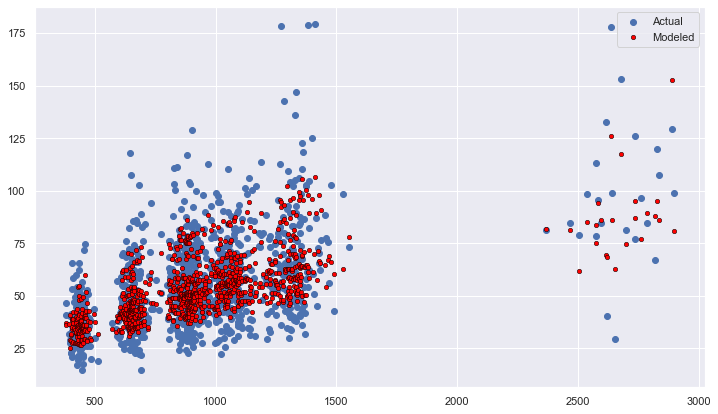

In [21]:
# visualize the actual and predicted relationships between
# spacing and EUR/ft:

plt.scatter(df['spacing'], df['eurpft'], label='Actual')
plt.scatter(df['spacing'], df['model_eur'], s=20, facecolor='red', edgecolor='black', lw=0.5, label='Modeled')
plt.legend()

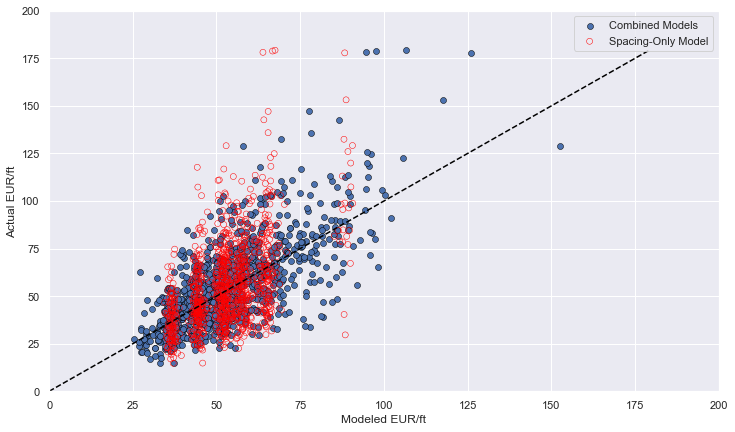

In [22]:
# visualize error trends, comparing the spacing-only model 
# to the combined (spacing + linear OLS) models:

ymod = df['model_eur']
plt.scatter(ymod, y, edgecolor='black', lw=0.5, label='Combined Models')

ymod0 = mod_sig(df['spacing'], *de_params)
plt.scatter(ymod0, y, facecolors='none', edgecolors='red', lw=0.5, label='Spacing-Only Model')

plt.ylabel('Actual EUR/ft')
plt.ylim(0,200)

plt.xlabel('Modeled EUR/ft')
plt.xlim(0,200)

line_max = max(ymod.max(), y.max())
linex = np.arange(0, line_max, 1)
liney = linex
plt.plot(linex, liney, c='black', ls='--')

plt.legend()

<AxesSubplot:ylabel='Count'>

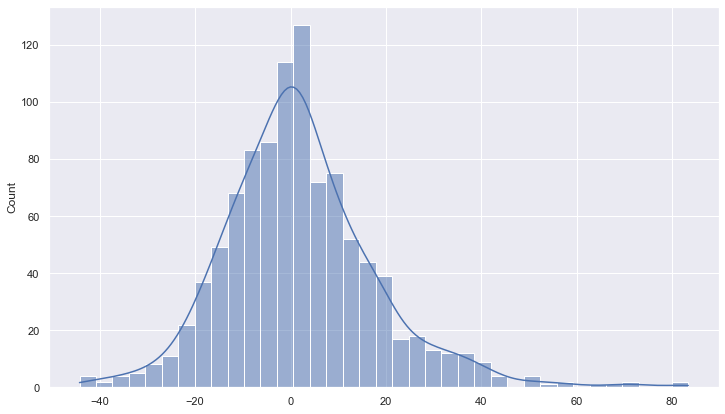

In [28]:
# visualize the distribution of residuals for the combined model:

resid = y - ymod

sns.histplot(resid, kde=True)

In [105]:
# compare MSE for spacing-only vs. combined:
print('MSE: \n\
Spacing-Only: %.2f \n\
Combined    : %.2f' %(mean_squared_error(y, ymod0), mean_squared_error(y, ymod)))

MSE: 
Spacing-Only: 401.95 
Combined    : 264.60


In [107]:
# compare MAE for spacing-only vs. combined:
print('MAE: \n\
Spacing-Only: %.2f \n\
Combined    : %.2f' %(mean_absolute_error(y, ymod0), mean_absolute_error(y, ymod)))

MAE: 
Spacing-Only: 14.72 
Combined    : 11.83


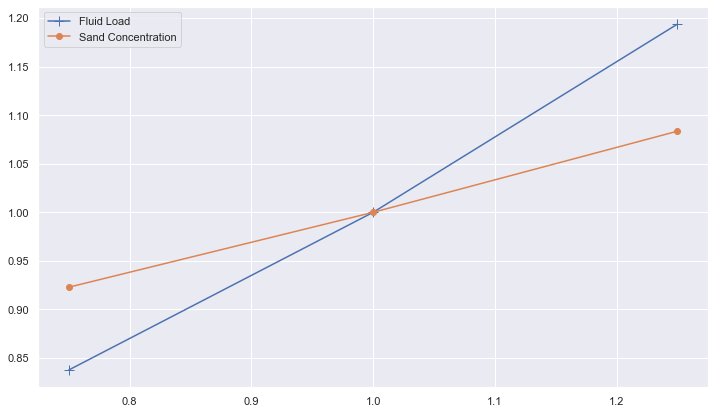

In [143]:
# examine the influence of fluid load and sand concentration as
# detected by the linear regression:

a = predict_eur(880, 45 * 0.75, 40)
b = predict_eur(880, 45, 40)
c = predict_eur(880, 45 * 1.25, 40)

aa = predict_eur(880, 45, 40 * 0.75)
cc = predict_eur(880, 45, 40 * 1.25)

plt.plot([0.75, 1, 1.25], [a/b, b/b, c/b], marker='+', ms=10, label='Fluid Load')
plt.plot([0.75, 1, 1.25], [aa/b, b/b, cc/b], marker='o', label='Sand Concentration')
plt.legend()